# Notebook 1: Data Retrieval and Preprocessing



## Accessing Data

In [7]:
from pathlib import Path

import xarray as xr
import numpy as np
import os
os.environ["ECCODES_DIR"] = "/home/nen/micromamba/envs/eccodes_env"
import eccodes
import matplotlib.pyplot as plt

from meteodatalab import data_source, grib_decoder
from meteodatalab.operators import time_operators as time_ops
from meteodatalab.operators.support_operators import get_grid_coords
from cartopy import crs as ccrs, feature as cfeature


In [8]:
source = data_source.FileDataSource(datafiles=["precip_20250122_06.grib"])
source

FileDataSource(request_template={}, datafiles=['precip_20250122_06.grib'])

In [9]:
request = {"param":["TOT_PREC"]}
ds_in = grib_decoder.load(source,request)

/tmp/ipykernel_12070/2775473017.py:9: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(x,y,z)


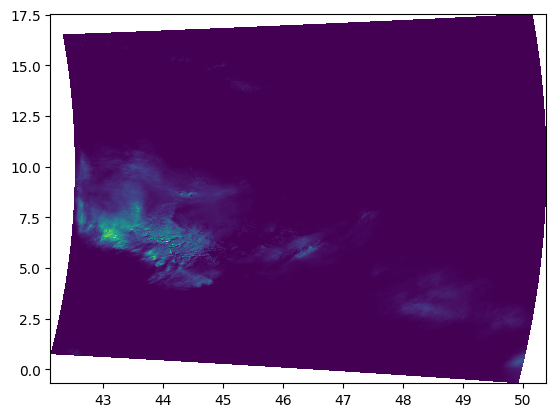

In [10]:
tot_prec_6h = ds_in["TOT_PREC"]
data = tot_prec_6h.isel(lead_time=1).median(dim="eps").clip(min=0)
data.attrs["geography"] = tot_prec_6h.geography

x = data.lat.data
y = data.lon.data
z = data.data[0]

plt.pcolormesh(x,y,z)


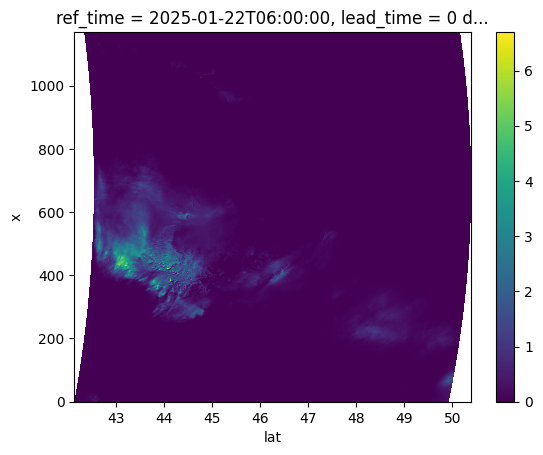

In [11]:
data.plot(x="lat")

Text(0.5, 1.0, 'Total Precipitation 6 hours')

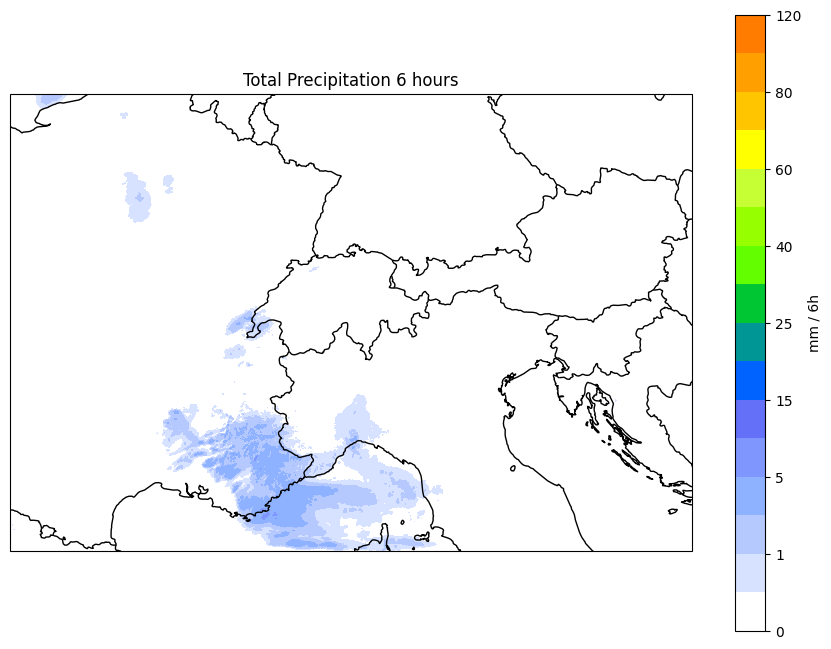

In [13]:
geo = data.geography
pol_lat = -1 * geo["latitudeOfSouthernPoleInDegrees"]
pol_lon = (geo["longitudeOfSouthernPoleInDegrees"] - 180) % 360
crs = ccrs.RotatedPole(pole_longitude=pol_lon, pole_latitude=pol_lat)
fig = plt.figure(figsize=(11,8))
ax = fig.add_subplot(1,1,1,projection=crs)
nx = geo["Ni"]
ny = geo["Nj"]

angle = geo["longitudeOfFirstGridPointInDegrees"]
lon_min = np.fmod(angle + 180, 360) - 180
lat_min = geo["latitudeOfFirstGridPointInDegrees"]

dlon = geo["iDirectionIncrementInDegrees"]
dlat = geo["jDirectionIncrementInDegrees"]

x = get_grid_coords(nx, lon_min, dlon, "x")
y = get_grid_coords(ny, lat_min, dlat, "y")

file_path = "colormap.txt"
path = Path(os.path.abspath(file_path))
with path.open() as f:
    it = iter(f)
    for _ in range(3):
        next(it)
    levels = [0.0] + [float(v) for v in next(it).split(" ")]
    colors = [tuple(int(v) / 255 for v in line.split(" ") if v) for line in it]

c = ax.contourf(
    x, y, data.values[0], transform=crs, levels=levels, colors=colors
)
fig.colorbar(c, label="mm / 6h")

ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.COASTLINE)

ax.set_title("Total Precipitation 6 hours")
